# Flight Data Analysis - Airbus

In [1]:
from __future__ import division

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import WeibullFitter
from lifelines import ExponentialFitter
from lifelines import LogNormalFitter

from scipy.stats import exponweib, lognorm
from scipy.stats import distributions

from numpy import arange, dot, exp, newaxis, pi, tensordot
from scipy.special import gamma, kv
from scipy.stats import rv_continuous

from vect import varange, vectorize

## I. Data Set

In [2]:
file_location = "./Dataset_ter.xlsx"
Removals = pd.read_excel(file_location, sheet_name='Removals')
SNlist = pd.read_excel(file_location, sheet_name='SN list')

In [3]:
Removals.info()
Removals.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2388 entries, 0 to 2387
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Customer                       2388 non-null   int64         
 1   Removal date                   2388 non-null   datetime64[ns]
 2   P/N                            2388 non-null   object        
 3   Description                    2388 non-null   object        
 4   S/N                            2388 non-null   object        
 5   Maintenance Type               2388 non-null   object        
 6   TSI (Flight Hours) at removal  2296 non-null   float64       
 7   TSN (Flight Hours) at Removal  2335 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 149.4+ KB


,Customer,Removal date,P/N,Description,S/N,Maintenance Type,TSI (Flight Hours) at removal,TSN (Flight Hours) at Removal
0,3,2015-01-01,C,PN_C,15323054356,Unscheduled,5819.0,5819.0
1,3,2015-01-01,C,PN_C,15323057041,Unscheduled,5819.0,5819.0
2,3,2015-01-03,C,PN_C,15323072973,Unscheduled,3036.0,3036.0
3,3,2015-01-07,C,PN_C,15323053425,Unscheduled,5614.0,5614.0
4,3,2015-01-07,C,PN_C,15323058236,Unscheduled,5614.0,5614.0


In [4]:
SNlist.info()
SNlist.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5785 entries, 0 to 5784
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Part Number                     5785 non-null   object 
 1   Description                     5785 non-null   object 
 2   Serial Number                   5785 non-null   object 
 3   Current SN Status Description   5785 non-null   object 
 4   Company                         5784 non-null   object 
 5   Hour ageing Since Installation  5745 non-null   float64
 6   Hour ageing Since New           5637 non-null   float64
 7   Since New Date                  4350 non-null   object 
dtypes: float64(2), object(6)
memory usage: 361.7+ KB


,Part Number,Description,Serial Number,Current SN Status Description,Company,Hour ageing Since Installation,Hour ageing Since New,Since New Date
0,A,PN_A,XXXM01-00324,On Aircraft,5,39498.39,54222.37,2007-11-19 00:00:00
1,A,PN_A,XXXM01-00329,On Aircraft,5,54525.41,54525.41,2007-11-19 00:00:00
2,A,PN_A,XXXM01-00334,On Aircraft,5,32238.92,52831.08,2008-03-12 00:00:00
3,A,PN_A,XXXM01-00337,On Aircraft,5,6951.19,52169.46,2006-04-01 00:00:00
4,A,PN_A,XXXM01-00338,On Aircraft,5,55511.55,55511.55,2008-03-12 00:00:00


##### Combining Removals and SNlist :

In [5]:
fail_and_not = SNlist.copy()
fail_and_not['failed'] = False
fail_and_not[fail_and_not['Current SN Status Description']=='In Outside Repair']=True
fail_and_not = fail_and_not.drop(['Description','Current SN Status Description','Since New Date','Company'], axis = 1)
fail_and_not = fail_and_not.rename(columns={"Part Number": "PN", "Serial Number": "SN", "Hour ageing Since Installation": "TSI", "Hour ageing Since New": "TSN"})
#dic_PN = {"C":"C","C-new":"C","A":"A","B":"B"}
dic_PN = {"C":"C","C-new":"C-new","A":"A","B":"B"}
fail_and_not["PN"] = fail_and_not.PN.map(dic_PN)

fail = Removals[Removals['Maintenance Type']=='Unscheduled']
fail = fail.drop(['Customer','Removal date','Description','Maintenance Type'], axis=1)
fail = fail.rename(columns={"P/N": "PN", "S/N": "SN", "TSI (Flight Hours) at removal": "TSI", "TSN (Flight Hours) at Removal": "TSN"})
fail['failed'] = True
fail['PN'] = fail.PN.map(dic_PN)

all_SN = pd.unique(fail_and_not['SN'])
SN_Removals = pd.unique(fail['SN'])

combined = pd.concat([fail,fail_and_not], ignore_index=True)
combined = combined.drop_duplicates(subset=['SN','PN','TSN'], keep='last')

In [6]:
pd.unique(combined['PN'])

array(['C', 'B', 'A', 'C-new', nan], dtype=object)

##### Data errors treatment

In [7]:
combined['TSI']=combined['TSI'].replace(np.nan, 0.0)
combined['TSN']=combined['TSN'].replace(np.nan, 0.0)
combined = combined[combined['TSN']!=0]
combined.head()

,PN,SN,TSI,TSN,failed
0,C,15323054356,5819,5819,True
1,C,15323057041,5819,5819,True
2,C,15323072973,3036,3036,True
3,C,15323053425,5614,5614,True
4,C,15323058236,5614,5614,True


In [8]:
print(len(set(combined['SN'])),'/',len(combined), 'distinct number part.')

6005 / 7758 distinct number part.


## II. Data Analysis

In [9]:
data = combined.copy()
alpha = 0.05 # coefficient related to confidence levels

In [10]:
types = ['A','B','C','C-new']
data_types = {}
for typ in types:
    data_types[typ] = data[data['PN']==typ]

In [11]:
def time_sticker(data_type): 
    T = data_type.TSI.to_numpy(dtype="float")
    d = np.array([1 if f == True else 0 for f in data_type.failed])
    return T,d

### 1. Nelson-Aalen and Kaplan-Meier estimators

We first consider the Nelson-Aalen estimator and the Kaplan-Meier estimator which will be used to compare with the model we apply for data in each cases.

(Note that we need to install the "lifelines" package for Python).

In [12]:
def NAF(typ,df=data_types): # Nelson_Aalen model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "NA-estimator of type " + typ
    return NelsonAalenFitter().fit(T,d,alpha=alpha,label=label)

def KMF(typ,df=data_types): # Kaplan_meier model
    data_type = df[typ]
    T,d=time_sticker(data_type)
    label = "KM-estimator of type " + typ
    return KaplanMeierFitter().fit(T,d,alpha=alpha,label=label)

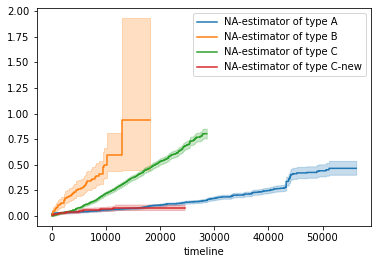

In [13]:
for typ in types:
    NAF(typ).plot(ci_show=True)

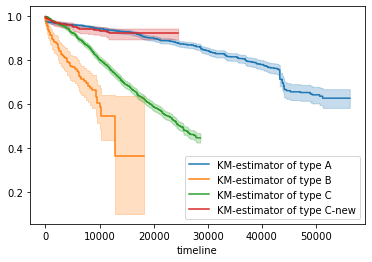

In [14]:
for typ in types:
    KMF(typ).plot(ci_show=True)

### 2. Parametric models

In [15]:
parametric_models = ['Exponential', 'Weibull', 'LogNormal']
dict_model = {}
for i,model in enumerate(parametric_models):
    dict_model[model] = i

In [16]:
def models(typ,df=data_types):
    data_type = df[typ]
    T,d=time_sticker(data_type)
    T[T==0]=1e-6 # Avoid divising by zero.
    exp_model = ExponentialFitter(alpha=alpha).fit(T,d)
    wb_model = WeibullFitter(alpha=alpha).fit(T,d)
    lognorm_model = LogNormalFitter(alpha=alpha).fit(T,d)
    return exp_model,wb_model,lognorm_model

In [17]:
def R_plot(typ,model): # We visualize if the model "model' can fit the data of type "typ"
    m = models(typ)[dict_model[model]]
    m.survival_function_.plot()
    KMF(typ).plot()
    plt.legend((model + ' model', 'KM-estimator'))
    plt.ylabel('Reliability function')
    plt.xlabel('Timeline')
    plt.title('Type ' + typ + ' data')

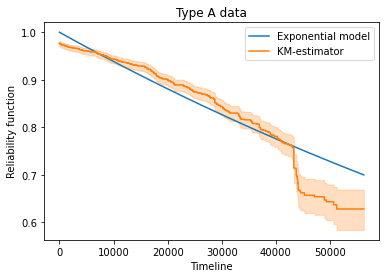

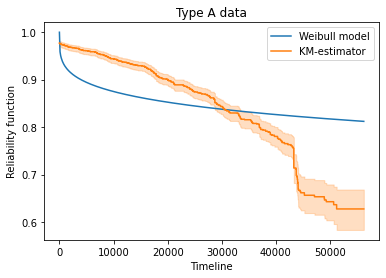

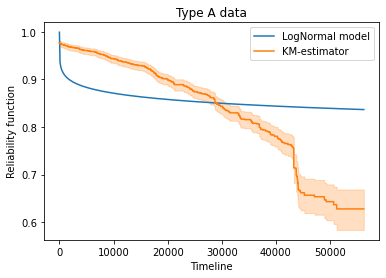

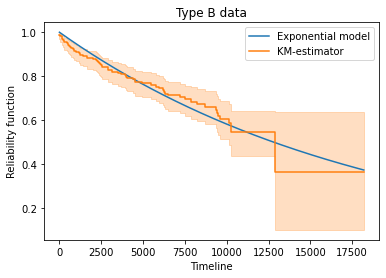

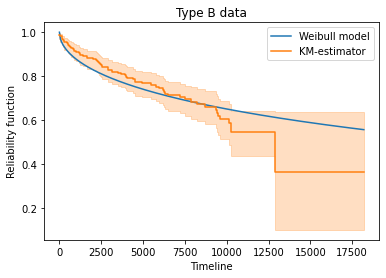

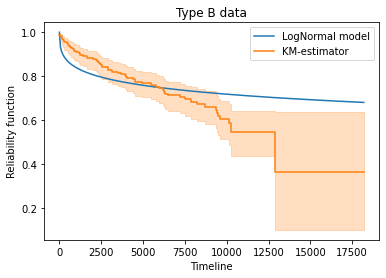

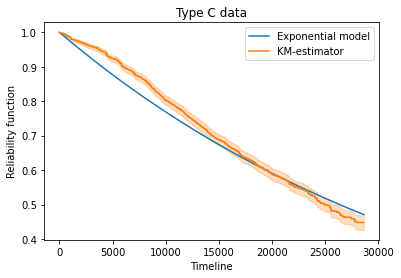

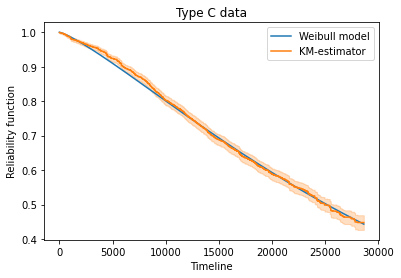

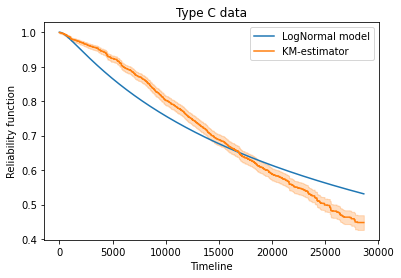

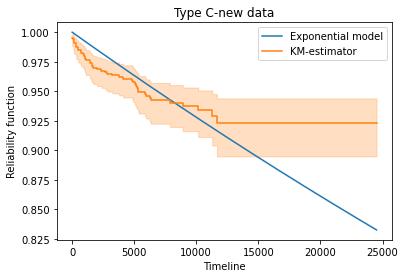

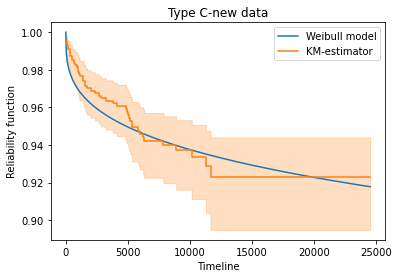

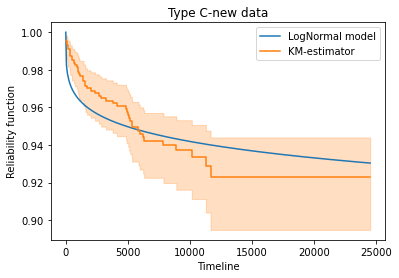

In [18]:
for typ in types:
    for model in parametric_models:
        R_plot(typ,model)

### 3. Choosing the best model by using statistical test:

Test model using Kolmogorov-Smirnov, Kramer-von Mise

In [19]:
def weib_R(x, alpha, beta):
    return np.exp(-np.power(x/alpha, beta))

def expo_R(x, lamb):
    return np.exp(-1/lamb*x)

def lognor_R(x, mu, std):
    return 1-lognorm.cdf(x,std)

def KStest(kap_meier, R, **args):
    x1 = kap_meier.timeline
    y1 = kap_meier.survival_function_.to_numpy().reshape((len(x1)))
    y2 = R(x1, **args)
    stat = np.max(np.abs(y1-y2))
    prob = distributions.kstwo.sf(stat, len(x1))
    return stat, prob

class cvm_unif_gen(rv_continuous):
    def _argcheck(self, samples):
        return samples > 0

    @vectorize(otypes=(float,))
    def _cdf(self, statistic, samples):
        low = 1 / (12 * samples)
        # Basic bounds.
        if statistic <= low:
            return 0.
        if statistic >= samples / 3:
            return 1.
        # From the geometric approach of Csorgo and Faraway.
        if statistic <= low + 1 / (4 * samples ** 2):
            return (gamma(samples + 1) / gamma(samples / 2 + 1) *
                                    (pi * (statistic - low)) ** (samples / 2))
        # Asymptotic distribution with a one-term correction.
        return cvm_unif_inf(statistic) + cvm_unif_fix1(statistic) / samples


cvm_unif = cvm_unif_gen(a=0, name='cvm-unif', shapes='samples')

inf_ks41 = 4 * arange(11) + 1
inf_args = inf_ks41 ** 2 / 16
inf_cs = (inf_ks41 ** .5 * gamma(varange(.5, 11)) /
                                        (pi ** 1.5 * gamma(varange(1, 11))))


def cvm_unif_inf(statistic):
    """
    Calculates the limiting distribution of the Cramer-von Mises statistic.

    After the second line of equation 1.3 from the Csorgo and Faraway paper.
    """
    args = inf_args / statistic
    return (inf_cs * exp(-args) * kv(.25, args)).sum() / statistic ** .5

fix1_args = (4 * (varange((.5, 1., 1.5), 21)) - 1) ** 2 / 16
fix1_dens = 72 * pi ** 1.5 * gamma(varange(1, 21))
fix1_csa = fix1_args ** .75 * gamma(varange(1.5, 21)) / fix1_dens
fix1_csb = fix1_args ** 1.25 * gamma(varange((.5, 1.5, 2.5), 21)) / fix1_dens


def cvm_unif_fix1(statistic):
    """
    Approximates the first-term of the small sample count Gotze expansion.

    After equation 1.10 (with coefficients pulled out as csa / csb).
    """
    args = fix1_args / statistic
    kvs = kv((.25, .75, 1.25), args[:, :, newaxis])
    gs, hs = exp(-args) * tensordot(((1, 1, 0), (2, 3, -1)), kvs, axes=(1, 2))
    a = dot((7, 16, 7), fix1_csa * gs).sum() / statistic ** 1.5
    b = dot((1, 0, 24), fix1_csb * hs).sum() / statistic ** 2.5
    return cvm_unif_inf(statistic) / 12 - a - b
    
def CVMtest(kap_meier, R, **args):
    x1 = kap_meier.timeline
    n = len(x1)
    y1 = kap_meier.survival_function_.to_numpy().reshape((n))
    y2 = np.linspace(1, np.min(y1), n)
    y3 = R(x1, **args)

    stat = 1/(12*n) + ((y3-y2)**2).sum()
    p_valeur = cvm_unif(n).sf(stat)
    return stat, p_valeur

C:\Users\ngocb\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
def best_model(typ,model_name=parametric_models): # this function returns name of the best model and the best model. 
    m_KM = KMF(typ)
    m_Exp, m_Weib, m_LogN = models(typ)
    m_ = [m_Exp, m_Weib, m_LogN]
    p_valeurs = [CVMtest(m_KM,expo_R,lamb=m_Exp.lambda_)[1],CVMtest(m_KM,weib_R,alpha=m_Weib.lambda_,beta=m_Weib.rho_)[1],CVMtest(m_KM,lognor_R,mu=m_LogN.mu_,std=m_LogN.sigma_)[1]]
    index_best_pvaleur = np.argmax(p_valeurs)   
    if index_best_pvaleur >= 0.05:
        return model_name[index_best_pvaleur],m_[index_best_pvaleur]
    else:
        return "Kaplan_Meier",m_KM

In [21]:
best_models = {}
for typ in types:
    best_models[typ] = best_model(typ)

Best model of type  A  is  Kaplan_Meier


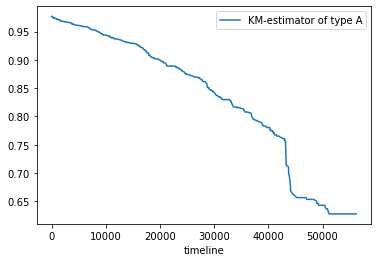

Best model of type  B  is  Kaplan_Meier


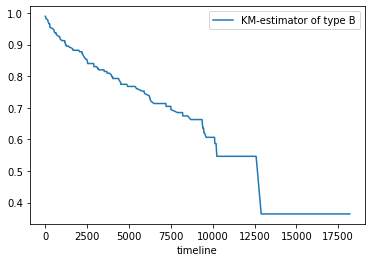

Best model of type  C  is  Weibull


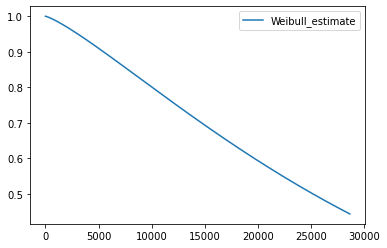

Best model of type  C-new  is  Kaplan_Meier


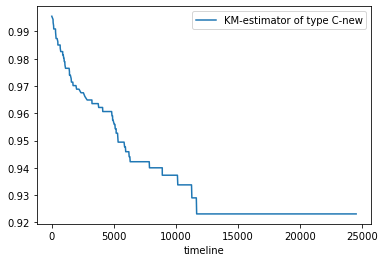

In [22]:
for typ in types:
    print("Best model of type ",typ, " is ", best_models[typ][0])
    best_models[typ][1].survival_function_.plot()
    plt.show()

In [30]:
# type B with exp
KStest(KMF('B'),expo_R,lamb=models('B')[dict_model['Exponential']].lambda_)

(0.13417271048870544, 0.001242052999409888)

In [31]:
# type B with weib
KStest(KMF('B'),weib_R,alpha=models('B')[dict_model['Weibull']].lambda_,beta=models('B')[dict_model['Weibull']].rho_)

(0.24908485576508954, 1.5808180552204035e-11)

In [32]:
# type B weib with tuned parameters, which returns a bigger p_valeur????
KStest(KMF('B'),weib_R,alpha=models('B')[dict_model['Exponential']].lambda_,beta=0.6)

(0.14805052252281825, 0.000249707748155184)

In [23]:
# type B with exp
CVMtest(KMF('B'),expo_R,lamb=models('B')[dict_model['Exponential']].lambda_) 

(2.0298252434032733, 1.0137775215857125e-05)

In [24]:
# type B with weib
CVMtest(KMF('B'),weib_R,alpha=models('B')[dict_model['Weibull']].lambda_,beta=models('B')[dict_model['Weibull']].rho_)

(2.913773242023708, 9.8780871926607e-08)

In [25]:
# type B weib with tuned parameters, which returns a bigger p_valeur????
CVMtest(KMF('B'),weib_R,alpha=models('B')[dict_model['Exponential']].lambda_,beta=0.6)

(0.35830150714355213, 0.09328980005791632)

In [26]:
# beta in Weib model of type B
b=models('B')[dict_model['Weibull']].rho_

In [27]:
# alpha
a=models('B')[dict_model['Weibull']].lambda_

In [49]:
print(a,b)

51535.889529611944 0.5169738481348314


In [28]:
# lambda estimated by exponential model of type B
l=models('B')[dict_model['Exponential']].lambda_

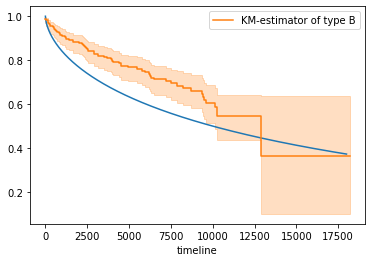

In [29]:
tt=np.linspace(0,18000,100000)
yy=[]
for i in range(len(tt)):
    #yy+=[expo_R(tt[i],l)]
    yy+=[weib_R(tt[i],l,0.6)] # type B weib with tuned parameters
plt.plot(tt,yy)
KMF('B').plot()

In [40]:
import numpy as np
from lifelines import AalenAdditiveFitter, CoxPHFitter
from lifelines.datasets import load_regression_dataset
from lifelines.utils import k_fold_cross_validation

df = load_regression_dataset()

#create the three models we'd like to compare.
aaf_1 = AalenAdditiveFitter(coef_penalizer=0.5)
aaf_2 = AalenAdditiveFitter(coef_penalizer=10)
cph = CoxPHFitter()

print(np.mean(k_fold_cross_validation(cph, df, duration_col='T', event_col='E', scoring_method="concordance_index")))
print(np.mean(k_fold_cross_validation(aaf_1, df, duration_col='T', event_col='E', scoring_method="concordance_index")))
print(np.mean(k_fold_cross_validation(aaf_2, df, duration_col='T', event_col='E', scoring_method="concordance_index")))

0.5770282826600035
0.5683433653251792
0.5758510490769345


In [34]:
df

,var1,var2,var3,T,E
0,0.595170,1.143472,1.571079,14.785652,1
1,0.209325,0.184677,0.356980,7.335846,1
2,0.693919,0.071893,0.557960,5.269797,1
3,0.443804,1.364646,0.374221,11.684092,1
4,1.613324,0.125566,1.921325,7.639492,1
...,...,...,...,...,...
195,0.137399,0.107748,0.354812,11.445457,1
196,0.637341,2.847188,1.459137,7.624627,1
197,1.109732,0.405561,0.018856,10.634620,1
198,0.031865,1.753759,0.252040,8.519718,1


<lifelines.SplineFitter:"Spline_estimate", fitted with 3317 total observations, 1745 right-censored observations>


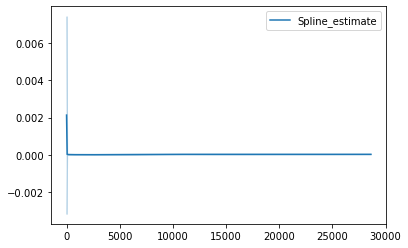

In [63]:
from lifelines.utils import find_best_parametric_model
from lifelines.datasets import load_lymph_node
from lifelines import SplineFitter

T,E = time_sticker(data_types['C'])
T[T==0]=1e-6

best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")

print(best_model)
# <lifelines.SplineFitter:"Spline_estimate", fitted with 686 total observations, 387 right-censored observations>

best_model.plot_hazard()

In [51]:
216/len(T)

0.06511908350919506

36170.006842556846


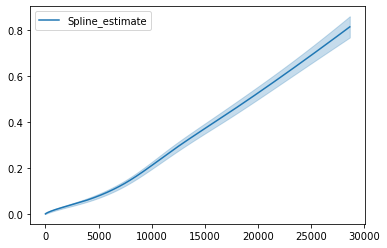

In [67]:
best_model.plot()

print(best_model.)

In [60]:
find_best_parametric_model?

In [64]:
SplineFitter?